# Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data

In [2]:
data_filename = 'tactics/data/stats/metrics_valid_maia1600.csv'
df = pd.read_csv(data_filename)

# Do analysis

In [3]:
df.describe()

,match,num_suggestions,correct_move,tactic_ground_div,tactic_ground_avg
count,8390.000000,4567.000000,4567.000000,4567.000000,4567.000000
mean,0.544338,2.713817,0.128312,315.504708,315.504708
std,0.498060,0.575633,0.334473,288.584141,288.584141
min,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,0.000000,64.000000,64.000000
50%,1.000000,3.000000,0.000000,192.000000,192.000000
75%,1.000000,3.000000,0.000000,597.000000,597.000000
max,1.000000,3.000000,1.000000,840.000000,840.000000


## Group by tactic

In [38]:
df_grouped = df.groupby('tactic_text')
df_grouped.describe()
agg = df_grouped.aggregate(np.nansum).reset_index()
mask = agg['tactic_text'].isin(['ground', 'engine_best'])
agg_masked = agg[~mask]
agg_masked

,tactic_text,match,num_suggestions,correct_move,tactic_ground_div,tactic_ground_avg
1,"f(A,B,C):-legal_move(B,C,A)",10,30.0,1.0,1961.0,1961.0
2,"f(A,B,C):-legal_move(B,C,A),attacks(B,C,A)",8,19.0,3.0,1534.0,1534.0
3,"f(A,B,C):-legal_move(B,C,A),attacks(B,C,A),att...",7,17.0,2.0,1580.0,1580.0
4,"f(A,B,C):-legal_move(B,C,A),attacks(B,C,A),att...",8,20.0,3.0,1534.0,1534.0
5,"f(A,B,C):-legal_move(B,C,A),attacks(B,C,A),att...",4,11.0,0.0,1640.0,1640.0
...,...,...,...,...,...,...
833,"f(A,B,C):-legal_move(B,C,A),behind(B,E,D,A),di...",4,12.0,0.0,1587.0,1587.0
834,"f(A,B,C):-legal_move(B,C,A),behind(B,E,D,A),di...",4,12.0,0.0,1587.0,1587.0
835,"f(A,B,C):-legal_move(B,C,A),behind(B,E,D,A),di...",4,12.0,0.0,1480.0,1480.0
836,"f(A,B,C):-legal_move(B,C,A),behind(B,E,D,A),di...",4,12.0,0.0,1587.0,1587.0


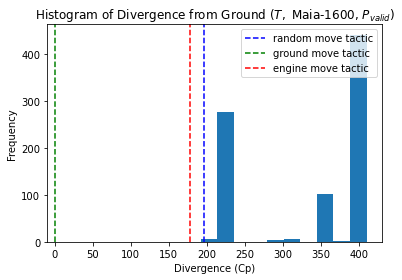

In [42]:
agg['avg_tactic_ground_div'] = agg['tactic_ground_div'] / agg['match']
mask = agg['tactic_text'].isin(['ground', 'engine_best'])
agg_masked = agg[~mask]
plt.hist(agg_masked['avg_tactic_ground_div'], bins=10)
plt.axvline(agg[agg['tactic_text'] == "f(A,B,C):-legal_move(B,C,A)"]['avg_tactic_ground_div'].values, linestyle='dashed', color='blue', label='random move tactic')
plt.axvline(agg[agg['tactic_text'] == "ground"]['avg_tactic_ground_div'].values, linestyle='dashed', color='green', label='ground move tactic')
plt.axvline(agg[agg['tactic_text'] == "engine_best"]['avg_tactic_ground_div'].values, linestyle='dashed', color='red', label='engine move tactic')
plt.title('Histogram of Divergence from Ground $(T,$ Maia-1600, $P_{valid})$')
plt.xlabel('Divergence (Cp)')
plt.ylabel('Frequency')
plt.xlim(left=-10)

plt.legend(loc=1)
plt.show()

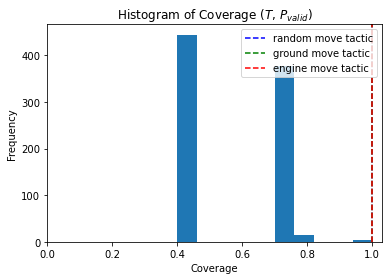

In [15]:
agg['coverage'] = agg['match'] / df.groupby(['position', 'move']).ngroups
plt.hist(agg['coverage'], bins=10)
plt.axvline(agg.loc[["f(A,B,C):-legal_move(B,C,A)"]]['coverage'].values, linestyle='dashed', color='blue', label='random move tactic')
plt.axvline(agg.loc[["ground"]]['coverage'].values, linestyle='dashed', color='green', label='ground move tactic')
plt.axvline(agg.loc[["engine_best"]]['coverage'].values, linestyle='dashed', color='red', label='engine move tactic')
plt.title('Histogram of Coverage $(T$, $P_{valid})$')
plt.xlabel('Coverage')
plt.ylabel('Frequency')
plt.xlim(left=0)

plt.legend(loc=1)
plt.show()

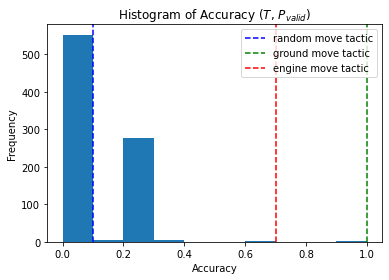

In [16]:
agg['accuracy'] = agg['correct_move'] / agg['match']
plt.hist(agg['accuracy'], bins=10)
plt.axvline(agg.loc[["f(A,B,C):-legal_move(B,C,A)"]]['accuracy'].values, linestyle='dashed', color='blue', label='random move tactic')
plt.axvline(agg.loc[["ground"]]['accuracy'].values, linestyle='dashed', color='green', label='ground move tactic')
plt.axvline(agg.loc[["engine_best"]]['accuracy'].values, linestyle='dashed', color='red', label='engine move tactic')
plt.title('Histogram of Accuracy $(T$, $P_{valid})$')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.xlim(right=None)

plt.legend(loc=1)
plt.show()

In [19]:
final = agg.sort_values(by = ['avg_tactic_ground_div'], ascending = [True])
final

,match,num_suggestions,correct_move,tactic_ground_div,tactic_ground_avg,avg_tactic_ground_div,coverage,accuracy
tactic_text,,,,,,,,
ground,10,10.0,10.0,0.0,0.0,0.00,1.0,1.000
engine_best,10,30.0,7.0,1778.0,1778.0,177.80,1.0,0.700
"f(A,B,C):-legal_move(B,C,A),attacks(B,C,A)",8,19.0,3.0,1534.0,1534.0,191.75,0.8,0.375
"f(A,B,C):-legal_move(B,C,A),attacks(B,D,A),attacks(B,C,A),different_pos(B,D),different_pos(B,C)",8,20.0,3.0,1534.0,1534.0,191.75,0.8,0.375
"f(A,B,C):-legal_move(B,C,A),attacks(B,C,A),different_pos(B,C)",8,19.0,3.0,1534.0,1534.0,191.75,0.8,0.375
...,...,...,...,...,...,...,...,...
"f(A,B,C):-legal_move(B,C,A),behind(B,D,C,A),behind(B,D,E,A),different_pos(D,E),different_pos(B,E)",4,12.0,0.0,1640.0,1640.0,410.00,0.4,0.000
"f(A,B,C):-legal_move(B,C,A),behind(B,D,C,A),behind(B,D,E,A),different_pos(D,E),different_pos(B,C)",4,12.0,0.0,1640.0,1640.0,410.00,0.4,0.000
"f(A,B,C):-legal_move(B,C,A),behind(B,D,C,A),behind(B,D,E,A),different_pos(D,E)",4,12.0,0.0,1640.0,1640.0,410.00,0.4,0.000


In [ ]:
list(final.index)

# Analyze Position Features

In [23]:
df['pos_move'] = df['position'] + "," + df['move']

In [24]:
df2 = df.groupby('pos_move')
agg = df2.aggregate(np.sum)
agg

,matches,divergence,avg,empty_suggestions,num_suggestions,correct_move,tactic_evals,ground_evals,best_move_evals,exec_time
pos_move,,,,,,,,,,
"3r4/1B3p1p/4pk2/2b2p2/Q1P5/P2P2PP/5n2/5R1K w - - 1 28,h1g2",325,33927.666667,33927.666667,144,329,2,-20303,19698,19698,35.411442
"4k3/p1p4p/1p4p1/8/8/P1Q5/5PPP/R2rK2R w KQ - 1 23,e1d1",332,13053.333333,13053.333333,137,346,9,-44656,-60970,-50652,35.921003
"8/3N4/7p/8/2K2Npk/P6P/5PP1/8 b - - 0 49,g4g3",16,448.166667,448.166667,453,23,10,637,29547,-4690,28.130674
"8/p7/1p6/1P2k3/PnP2R2/2K5/4N3/8 b - - 6 47,b4a2",2,226.666667,226.666667,467,6,0,-448,54404,54404,28.712242
"r1b1qb1r/3nk1p1/2P1p2p/p3Pp1Q/4p3/B6P/P1B2PPN/R4RK1 b - - 0 18,e7d8",2,0.000000,0.000000,467,4,2,50,11725,11725,27.353722
"r1b2rk1/pp3ppp/2n2n2/q1Pp2N1/8/P3P3/1QP2PPP/RN2KB1R w KQ - 1 13,b2c3",2,43.333333,43.333333,467,6,0,-76,12663,6566,30.567458
"r3k2B/p1p2p1p/p6n/3b4/8/5N2/P2N1PPP/R3R1K1 b q - 1 16,d5e6",2,84.000000,84.000000,467,6,0,244,-1876,67067,28.251340
"r4r2/1k1nq3/4p1p1/NP1bPp2/3P3p/3BQ3/1P3PPP/R1R3K1 b - - 0 27,a8a5",325,105.333333,105.333333,144,329,323,-69559,-100835,-21574,36.631233
"rn1k1Q2/pbpp2b1/1p6/8/3P4/2N3N1/PPP3PP/4RRK1 b - - 0 21,g7f8",325,0.000000,0.000000,144,325,325,118950,171654,171654,34.761903


Text(0, 0.5, 'Frequency')

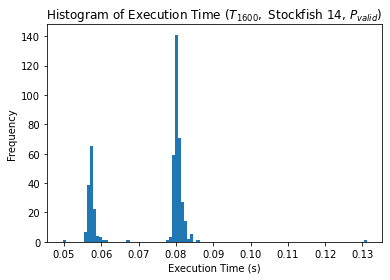

In [17]:
plt.hist(agg['exec_time'], bins=100)
plt.title('Histogram of Execution Time $(T_{1600},$ Stockfish 14, $P_{valid})$')
plt.xlabel('Execution Time (s)')
plt.ylabel('Frequency')

In [18]:
high_exec = agg[agg['exec_time'] > 100]
high_exec = high_exec.sort_values(by = ['exec_time'], ascending = [False])
high_exec

,matches,divergence,avg,empty_suggestions,num_suggestions,correct_move,tactic_evals,ground_evals,best_move_evals,exec_time
tactic_text,,,,,,,,,,


Text(0, 0.5, 'Frequency')

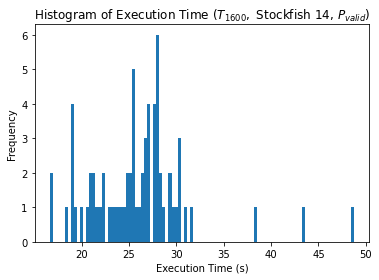

In [13]:
low_exec = agg[agg['exec_time'] <= 100]
plt.hist(low_exec['exec_time'], bins=100)
plt.title('Histogram of Execution Time $(T_{1600},$ Stockfish 14, $P_{valid})$')
plt.xlabel('Execution Time (s)')
plt.ylabel('Frequency')

In [26]:
num_exs = [1, 5, 20, 100]
time_vals = [27.5, 60 + 33, 60 * 6 + 33, 33 * 60 + 8]
num_tactics = [9, 117, 469, 837]

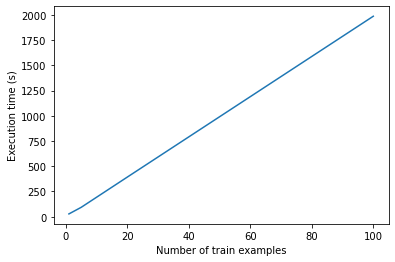

In [27]:
plt.plot(num_exs, time_vals)
plt.xlabel('Number of train examples')
plt.ylabel('Execution time (s)')
plt.show()

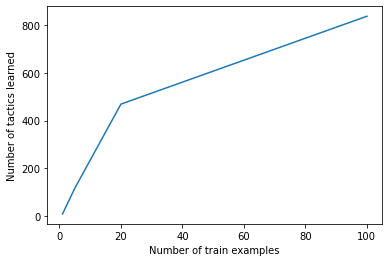

In [28]:
plt.plot(num_exs, num_tactics)
plt.xlabel('Number of train examples')
plt.ylabel('Number of tactics learned')
plt.show()

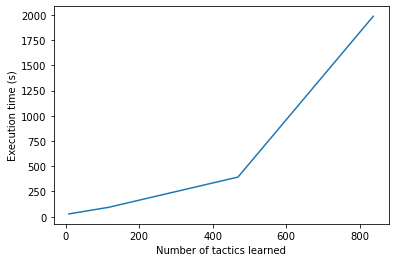

In [29]:
plt.plot(num_tactics, time_vals)
plt.xlabel('Number of tactics learned')
plt.ylabel('Execution time (s)')
plt.show()

# Calculate Dataset Metrics

In [ ]:
from collections import Counter

total_games = 0
valid_elo = 0
total_pos = 0
total_elo = 0
game_count = Counter()

pgn_path = 'tactics/data/lichess_db_standard_rated_2013-01.pgn'

In [ ]:
offsets = []
handle = open(pgn_path)
header = chess.pgn.read_headers(handle)

In [ ]:
header.get('Termination')


In [ ]:
import chess.pgn

with open(pgn_path) as pgn:
    while game := chess.pgn.read_game(pgn):
        total_games += 1
        white_elo = game.headers['WhiteElo']
        black_elo = game.headers['BlackElo']
        if '?' not in white_elo and '?' not in black_elo:
            total_elo += int(white_elo)
            total_elo += int(black_elo)
            valid_elo += 1
        game_count[game.headers['Event']] += 1

In [ ]:
print('Total games', total_games)
avg_elo = total_elo / (2 * valid_elo)
print('Average ELO', avg_elo)

In [ ]:
variance = 0

with open(pgn_path) as pgn:
    while game := chess.pgn.read_game(pgn):
        total_games += 1
        white_elo = game.headers['WhiteElo']
        black_elo = game.headers['BlackElo']
        if '?' not in white_elo and '?' not in black_elo:
            variance += (int(white_elo) - avg_elo) ** 2
            variance += (int(black_elo) - avg_elo) ** 2
        game_count[game.headers['Event']] += 1

In [ ]:
import math

print('SD', math.sqrt(variance / valid_elo))

# Test Evaluation

In [67]:
import chess
import chess.engine
from tactics.util import *

board = chess.Board('r1bqkb1r/ppp1pnpp/3p4/7Q/8/3B4/PPP2PPP/RNB2RK1 w kq - 0 10')
move_names = [
    'b1c3',
    'c1g5',
    'd3c4',
    'f1e1'
]
moves = [chess.Move.from_uci(move_name) for move_name in move_names]
engine_path = get_lc0_cmd(LC0, MAIA_1600) + ['--nncache=0']
#engine_path = STOCKFISH
mate_score = 2000
n = 10

In [68]:
with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:
    tmp_analysis = engine.analyse(board, limit=chess.engine.Limit(nodes=1), multipv=n, game=object())
    top_results = [(root['pv'][0], root['score'].relative.score(mate_score=mate_score)) for root in tmp_analysis]
    top_n_results = top_results[:n]
top_n_results

<UciProtocol (pid=15841)>: stderr >>        _
<UciProtocol (pid=15841)>: stderr >> |   _ | |
<UciProtocol (pid=15841)>: stderr >> |_ |_ |_| v0.30.0-dev+git.bfa5b7d built May 17 2022
<UciProtocol (pid=15841)>: stderr >> Loading weights file from: tactics/bin/maia_weights/maia-1600.pb
<UciProtocol (pid=15841)>: stderr >> Creating backend [eigen]...
<UciProtocol (pid=15841)>: stderr >> Using Eigen version 3.3.7
<UciProtocol (pid=15841)>: stderr >> Eigen max batch size is 256.


[(Move.from_uci('b1c3'), 22),
 (Move.from_uci('d3c4'), 22),
 (Move.from_uci('f1e1'), 22),
 (Move.from_uci('c1g5'), 22),
 (Move.from_uci('d3h7'), 22),
 (Move.from_uci('c1f4'), 22),
 (Move.from_uci('h5d5'), 22),
 (Move.from_uci('f2f4'), 22),
 (Move.from_uci('b2b3'), 22),
 (Move.from_uci('c1e3'), 22)]

In [59]:
with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:
    all_evals = get_evals(engine, board, board.legal_moves)
    all_evals.sort(key=lambda eval: eval[1], reverse=True)
    top_n_results = all_evals[:n]
top_n_results

<UciProtocol (pid=14473)>: stderr >>        _
<UciProtocol (pid=14473)>: stderr >> |   _ | |
<UciProtocol (pid=14473)>: stderr >> |_ |_ |_| v0.30.0-dev+git.bfa5b7d built May 17 2022
<UciProtocol (pid=14473)>: stderr >> Loading weights file from: tactics/bin/maia_weights/maia-1600.pb
<UciProtocol (pid=14473)>: stderr >> Creating backend [eigen]...
<UciProtocol (pid=14473)>: stderr >> Using Eigen version 3.3.7
<UciProtocol (pid=14473)>: stderr >> Eigen max batch size is 256.


{'depth': 1, 'seldepth': 1, 'time': 0.003, 'nodes': 1, 'score': PovScore(Cp(+22), WHITE), 'tbhits': 0, 'pv': [Move.from_uci('b1c3')], 'string': 'node  (  48) N:       1 (+ 0) (P:  0.00%) (WL:  0.15486) (D: 0.031) (M:  0.0) (Q:  0.15486) (V:  0.1549) '}
{'depth': 1, 'seldepth': 1, 'time': 0.004, 'nodes': 1, 'score': PovScore(Cp(-16), BLACK), 'tbhits': 0, 'pv': [Move.from_uci('h8h7')], 'string': 'node  (  24) N:       1 (+ 0) (P:  0.00%) (WL: -0.11692) (D: 0.041) (M:  0.0) (Q: -0.11692) (V: -0.1169) '}
{'depth': 1, 'seldepth': 1, 'time': 0.003, 'nodes': 1, 'score': PovScore(Cp(+22), WHITE), 'tbhits': 0, 'pv': [Move.from_uci('b1c3')], 'string': 'node  (  48) N:       1 (+ 0) (P:  0.00%) (WL:  0.15486) (D: 0.031) (M:  0.0) (Q:  0.15486) (V:  0.1549) '}
{'depth': 1, 'seldepth': 1, 'time': 0.003, 'nodes': 1, 'score': PovScore(Cp(+14), BLACK), 'tbhits': 0, 'pv': [Move.from_uci('e8f7')], 'string': 'node  (   2) N:       1 (+ 0) (P:  0.00%) (WL:  0.09887) (D: 0.039) (M:  0.0) (Q:  0.09887) (V: 

[(Move.from_uci('d3h7'), 0.052999999999999936),
 (Move.from_uci('d3c4'), 0.013000000000000012),
 (Move.from_uci('f1e1'), 0.007000000000000006),
 (Move.from_uci('c1g5'), 0.006000000000000005),
 (Move.from_uci('b1d2'), 0.0050000000000000044),
 (Move.from_uci('b1c3'), 0.0040000000000000036),
 (Move.from_uci('c1f4'), 0.0030000000000000027),
 (Move.from_uci('c1d2'), 0.0030000000000000027),
 (Move.from_uci('b1a3'), 0.0030000000000000027),
 (Move.from_uci('f2f4'), 0.0020000000000000018)]

In [69]:
def get_evals(engine: chess.engine.SimpleEngine, board: chess.Board, suggestions: List[chess.Move], mate_score: int=2000) -> List[Tuple[chess.Move, int]]:
    "Obtain engine evaluations for a list of moves in a given position"

    evals = []
    for move in suggestions:
        tmp_board = chess.Board(board.fen())
        tmp_board.push(move)
        if tmp_board.outcome() is not None:
            move_score = mate_score if tmp_board.is_checkmate() else -mate_score
            evals.append((move, move_score))
            continue
        limit = chess.engine.Limit(nodes=1)
        # prev_eval = engine.analyse(board, limit=limit, game=object()) # https://stackoverflow.com/a/66251120
        # print(prev_eval) 
        curr_eval = engine.analyse(tmp_board, limit=limit, game=object())
        print(curr_eval)
        orig_turn = board.turn
        if 'pv' in curr_eval:
            # prev_score = prev_eval['score'].pov(orig_turn)
            curr_score = curr_eval['score'].pov(orig_turn)
            move_score = curr_score.score(mate_score=mate_score)
            evals.append((move, move_score))
    return evals

In [70]:
with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:
    evals = get_evals(engine, board, moves)
evals

<UciProtocol (pid=16002)>: stderr >>        _
<UciProtocol (pid=16002)>: stderr >> |   _ | |
<UciProtocol (pid=16002)>: stderr >> |_ |_ |_| v0.30.0-dev+git.bfa5b7d built May 17 2022
<UciProtocol (pid=16002)>: stderr >> Loading weights file from: tactics/bin/maia_weights/maia-1600.pb
<UciProtocol (pid=16002)>: stderr >> Creating backend [eigen]...
<UciProtocol (pid=16002)>: stderr >> Using Eigen version 3.3.7
<UciProtocol (pid=16002)>: stderr >> Eigen max batch size is 256.


{'depth': 1, 'seldepth': 1, 'time': 0.002, 'nodes': 1, 'score': PovScore(Cp(-26), BLACK), 'tbhits': 0, 'pv': [Move.from_uci('g7g6')]}
{'depth': 1, 'seldepth': 1, 'time': 0.002, 'nodes': 1, 'score': PovScore(Cp(-28), BLACK), 'tbhits': 0, 'pv': [Move.from_uci('g7g6')]}
{'depth': 1, 'seldepth': 1, 'time': 0.002, 'nodes': 1, 'score': PovScore(Cp(-35), BLACK), 'tbhits': 0, 'pv': [Move.from_uci('g7g6')]}
{'depth': 1, 'seldepth': 1, 'time': 0.002, 'nodes': 1, 'score': PovScore(Cp(-29), BLACK), 'tbhits': 0, 'pv': [Move.from_uci('g7g6')]}


[(Move.from_uci('b1c3'), 26),
 (Move.from_uci('c1g5'), 28),
 (Move.from_uci('d3c4'), 35),
 (Move.from_uci('f1e1'), 29)]